# Amulet Tensorflow training

ติดตั้ง tensorflow

In [5]:
pip install tensorflow-macos numpy matplotlib opencv-python Pillow

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 173.9 MB 1.9 MB/s            
     |████████████████████████████████| 17.6 MB 3.0 MB/s            
     |████████████████████████████████| 7.3 MB 1.6 MB/s            
     |████████████████████████████████| 46.0 MB 1.7 MB/s            
     |████████████████████████████████| 3.0 MB 1.9 MB/s            
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached tensorflow_estimator-2.7.0-py2.py3-none-any.whl (463 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 3.1 MB 3.2 MB/s            
  Using cached keras-2.7.0-py2.py3-none-any.whl (1.3 MB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl

นำเข้า tensorflow, numpy และ matplotlib

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import cv2
import PIL
import imghdr
import os


Unable to revert mtime: /Library/Fonts
Fontconfig warning: ignoring UTF-8: not a valid region tag


In [7]:
data_dir = pathlib.Path('./models')

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

362


In [9]:
labtop = list(data_dir.glob('laptop/*.jpg'))
glass = list(data_dir.glob('glass/*.jpg'))
keyboard = list(data_dir.glob('keyboard/*.jpg'))
monitor = list(data_dir.glob('monitor/*.jpg'))
bottle = list(data_dir.glob('bottle/*.jpg'))

In [10]:
batch_size = 32
img_height = 200
img_width = 200

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 363 files belonging to 7 classes.
Using 291 files for training.


2022-01-13 12:04:47.444168: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 363 files belonging to 7 classes.
Using 72 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['bicycle', 'bottle', 'glass', 'headphones', 'keyboard', 'laptop', 'monitor']


In [14]:
def check_images(s_dir, ext_list):
    bad_images = []
    bad_ext = []
    s_list = os.listdir(s_dir)
    for klass in s_list:
        klass_path = os.path.join(s_dir, klass)
        print('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list = os.listdir(klass_path)
            for f in file_list:
                f_path = os.path.join(klass_path, f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                    bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img = cv2.imread(f_path)
                        shape = img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ',
                          f, ' in class directory ', klass)
        else:
            print('*** WARNING*** you have files in ', s_dir,
                  ' it should only contain sub directories')
    return bad_images, bad_ext


good_exts = ['jpg', 'png', 'jpeg', 'gif', 'bmp']
bad_file_list, bad_ext_list = check_images(data_dir, good_exts)
if len(bad_file_list) != 0:
    print('improper image files are listed below')
    for i in range(len(bad_file_list)):
        print(bad_file_list[i])
        # delete bad files
        os.remove(bad_file_list[i])
else:
    print(' no improper image files were found')


processing class directory  monitor
processing class directory  .DS_Store
*** WARNING*** you have files in  models  it should only contain sub directories
processing class directory  headphones


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


processing class directory  glass
processing class directory  bicycle


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


processing class directory  laptop


libpng warning: iCCP: known incorrect sRGB profile


processing class directory  bottle
processing class directory  keyboard
 no improper image files were found


2022-01-13 12:04:55.981744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-01-13 12:04:56.016365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-01-13 12:04:56.311746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


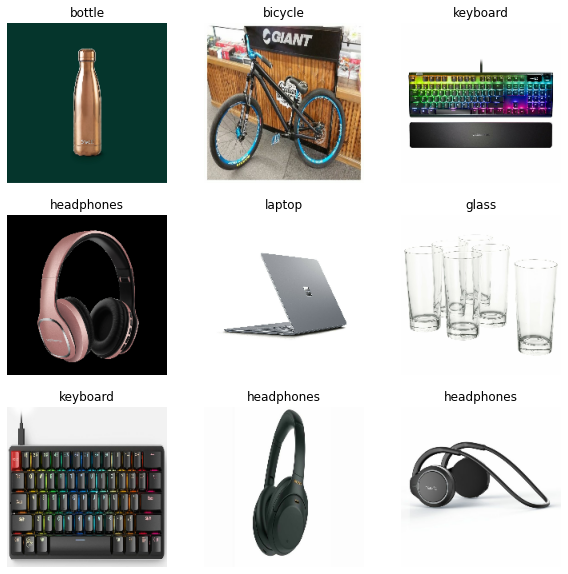

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



In [16]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


2022-01-13 12:04:58.737966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-01-13 12:04:58.777965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-01-13 12:04:59.034764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


(32, 200, 200, 3)
(32,)


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [19]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2022-01-13 12:05:01.135396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-01-13 12:05:01.171705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-01-13 12:05:01.431090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


0.0 1.0


In [20]:
num_classes = len(class_names)

layers = tf.keras.layers
Sequential = tf.keras.models.Sequential

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        1

In [23]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 2.2619 - accuracy: 0.1546

2022-01-13 12:05:06.714247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-01-13 12:05:06.997429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/10 [==============================] - 4s 394ms/step - loss: 2.2619 - accuracy: 0.1546 - val_loss: 1.9171 - val_accuracy: 0.1667
Epoch 2/10
10/10 [==============================] - 3s 313ms/step - loss: 1.8417 - accuracy: 0.2165 - val_loss: 1.7155 - val_accuracy: 0.3056
Epoch 3/10
10/10 [==============================] - 3s 327ms/step - loss: 1.5251 - accuracy: 0.4536 - val_loss: 1.4465 - val_accuracy: 0.4722
Epoch 4/10
10/10 [==============================] - 4s 427ms/step - loss: 1.0995 - accuracy: 0.6220 - val_loss: 1.4037 - val_accuracy: 0.5139
Epoch 5/10
10/10 [==============================] - 4s 357ms/step - loss: 0.8139 - accuracy: 0.7354 - val_loss: 1.0951 - val_accuracy: 0.6667
Epoch 6/10
10/10 [==============================] - 4s 350ms/step - loss: 0.4895 - accuracy: 0.8316 - val_loss: 1.2977 - val_accuracy: 0.5833
Epoch 7/10
10/10 [==============================] - 4s 365ms/step - loss: 0.3354 - accuracy: 0.8763 - val_loss: 1.1193 - val_accuracy: 0.6667
Epoch 8/10
10/10 

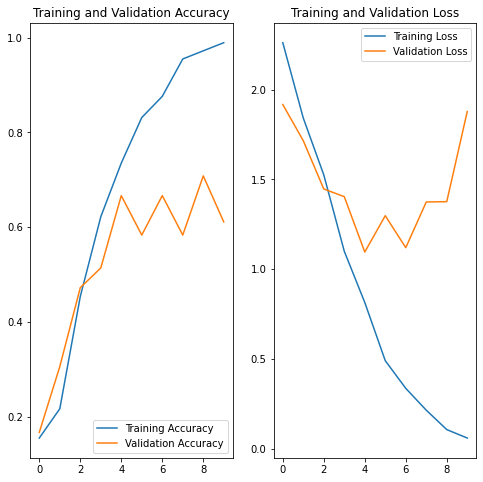

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

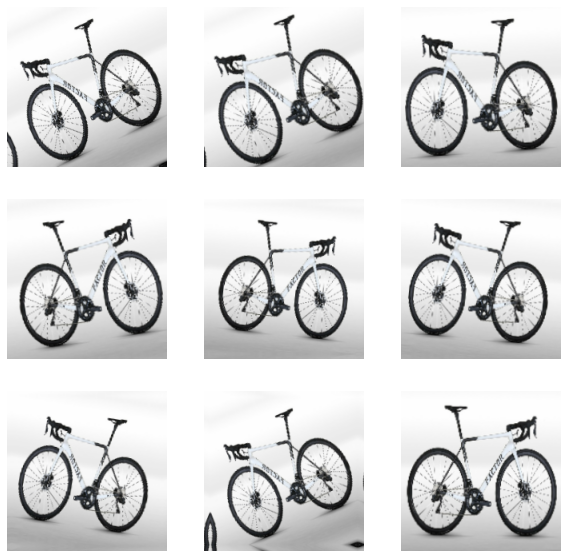

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [27]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 100, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                  

In [30]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
10/10 [==============================] - 5s 444ms/step - loss: 2.2941 - accuracy: 0.1306 - val_loss: 1.9393 - val_accuracy: 0.1806
Epoch 2/15
10/10 [==============================] - 4s 419ms/step - loss: 1.9169 - accuracy: 0.1959 - val_loss: 1.8834 - val_accuracy: 0.2639
Epoch 3/15
10/10 [==============================] - 4s 420ms/step - loss: 1.8571 - accuracy: 0.2199 - val_loss: 1.7198 - val_accuracy: 0.3056
Epoch 4/15
10/10 [==============================] - 4s 408ms/step - loss: 1.7513 - accuracy: 0.3230 - val_loss: 1.7050 - val_accuracy: 0.3611
Epoch 5/15
10/10 [==============================] - 4s 447ms/step - loss: 1.7058 - accuracy: 0.3574 - val_loss: 1.4955 - val_accuracy: 0.4028
Epoch 6/15
10/10 [==============================] - 4s 452ms/step - loss: 1.5442 - accuracy: 0.4467 - val_loss: 1.4308 - val_accuracy: 0.4444
Epoch 7/15
10/10 [==============================] - 4s 413ms/step - loss: 1.4721 - accuracy: 0.4433 - val_loss: 1.4165 - val_accuracy: 0.4306
Epoch 

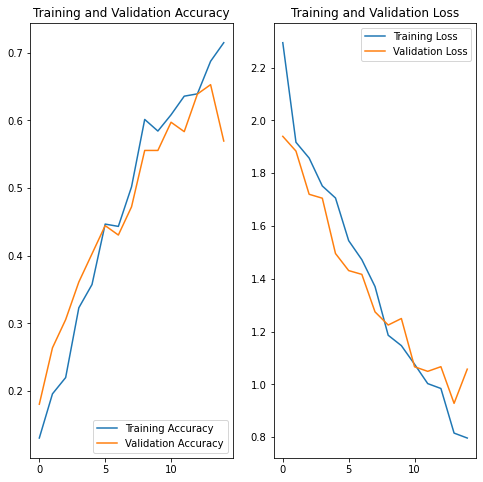

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
img = tf.keras.utils.load_img('./test/nb2.jpg', target_size=(img_height, img_width))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to laptop with a 52.20 percent confidence.


In [33]:
# Export model to file
export_path = "./saved_model/"

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(export_path + 'model.tflite', 'wb') as f:
    f.write(tflite_model)

# print success message
print("Successfully exported model to: {}".format(export_path))


2022-01-13 12:06:45.095567: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-01-13 12:06:46.228107: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-01-13 12:06:46.228500: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-01-13 12:06:46.244173: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1149] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.5ms.
  function_optimizer: function_optimizer did nothing. time = 0.01ms.

2022-01-13 12:06:46.700879: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2022-01-13 12:06:46.700931: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366

Successfully exported model to: ./saved_model/


In [34]:
# export to h5 file
def exportH5():
    model.save(export_path + 'model.h5')
    print("Successfully exported model to: {}".format(export_path))
    
exportH5()

Successfully exported model to: ./saved_model/


In [35]:
# export labels to txt file
with open(export_path + 'labels.txt', 'w') as f:
    
    for label in class_names:
        f.write(label + '\n')

In [36]:
tflite_convert \
  --keras_model_file=saved_model/model.h5 \
  --output_file=saved_model/mobilenet.tflite

AttributeError: module 'tensorflow._api.v2.lite' has no attribute 'constants'